In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abstract_udmis import AbstractUDMIS
import networkx as nx

### We are going to use some nice function form torch to implement the cooling schedules for the annealing

In [2]:
import torch
from torch import optim

## Task 1: Simulated Classical Annealing

for this task we are going to use the functions and abstract classes provided in the Task1.ipynb.

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
        
    def find_edges(self):
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices - 1):
            x_i, y_i = graph[i]
            
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j]
                
                
                #calc distance
                dij = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
    
    def energy(self):
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices - 1):
            for j in range(i+1, self.num_vertices):
                
                
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                    
            vertex_term += self.occupations[i]
            
        #missed last vertex
        vertex_term += self.occupations[self.num_vertices - 1]
        
        return u*interaction_term - vertex_term
    
    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping occupied vertex
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
            
        elif self.occupations[i] == 0:
            #flipping unnocupied vertex
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied
            
        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        return np.random.randint(self.num_vertices)
    
    
    def draw_graph(self):
        G = nx.from_numpy_array(self.edges)
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        cs = self.occupations

        fig, ax = plt.subplots()
        
        # plot the non activated vertices in the background
        for x,y,c in zip(xs,ys,cs):
            if not(c):
                circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                ax.add_patch(circle)
                
        for x,y,c in zip(xs,ys,cs):
            if c:
                circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                ax.add_patch(circle)
        
        nx.draw(G, pos=self.graph, node_color='r', edge_color='b',ax=ax)
        ax.axis('equal')
        
        return fig,ax

In [4]:
def draw_graph_state(graph,occupationlist, ax):
    G = nx.from_numpy_array(graph.edges)
    graph_np = np.array(graph.graph)
    xs = graph_np[:,0]
    ys = graph_np[:,1]
    cs = occupationlist

    # plot the non activated vertices in the background
    for x,y,c in zip(xs,ys,cs):
        if not(c):
            circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
            ax.add_patch(circle)

    for x,y,c in zip(xs,ys,cs):
        if c:
            circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
            ax.add_patch(circle)

    nx.draw(G, pos=graph.graph, node_color='r', edge_color='b',ax=ax)
    ax.axis('equal')

In [29]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

In [6]:
#density = 1
#scale = np.sqrt(25)/density
#graph = [(np.random.rand()*scale,np.random.rand()*scale) for n in range(25)]

In [54]:
udmis = UDMIS(u,graph)

6


### Now the fun part, we are going to use the learning rate schedule to define a set of annealing schedules we want to investigate, lets first use the proposed one as our benchmark

In [55]:
N = 100
t = np.arange(N+1)
T_i = 100
T_f = 0.01

In [56]:
#proposed annealing schedule
T = T_i * ((T_f/T_i)**(t/N))

it will be interest for us to collect the informations from the energy during the annealing routine

In [57]:
annealing_baseline = np.zeros((N,3))
occupation_states = []
for i,t in enumerate(range(N)):
    temp = T[t]
    E, dE = udmis.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis.occupations))
    annealing_baseline[i,0] = temp
    annealing_baseline[i,1] = E
    annealing_baseline[i,2] = dE

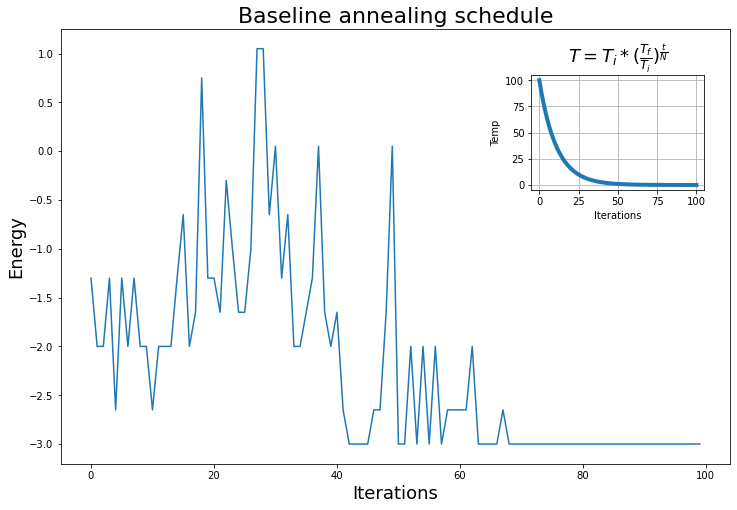

In [58]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_baseline[:,1])
plt.title('Baseline annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .60, .20, .20])
plt.title('$T = T_i * (\\frac{T_f}{T_i})^{\\frac{t}{N}}$', fontsize=18)
plt.plot(np.arange(N+1),T, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/Baseline_annealing.pdf', dpi=250, bbox_inches='tight')

In [69]:
for i in range(100):
    if i % (100//4) == 0:
        print(i)

0
25
50
75


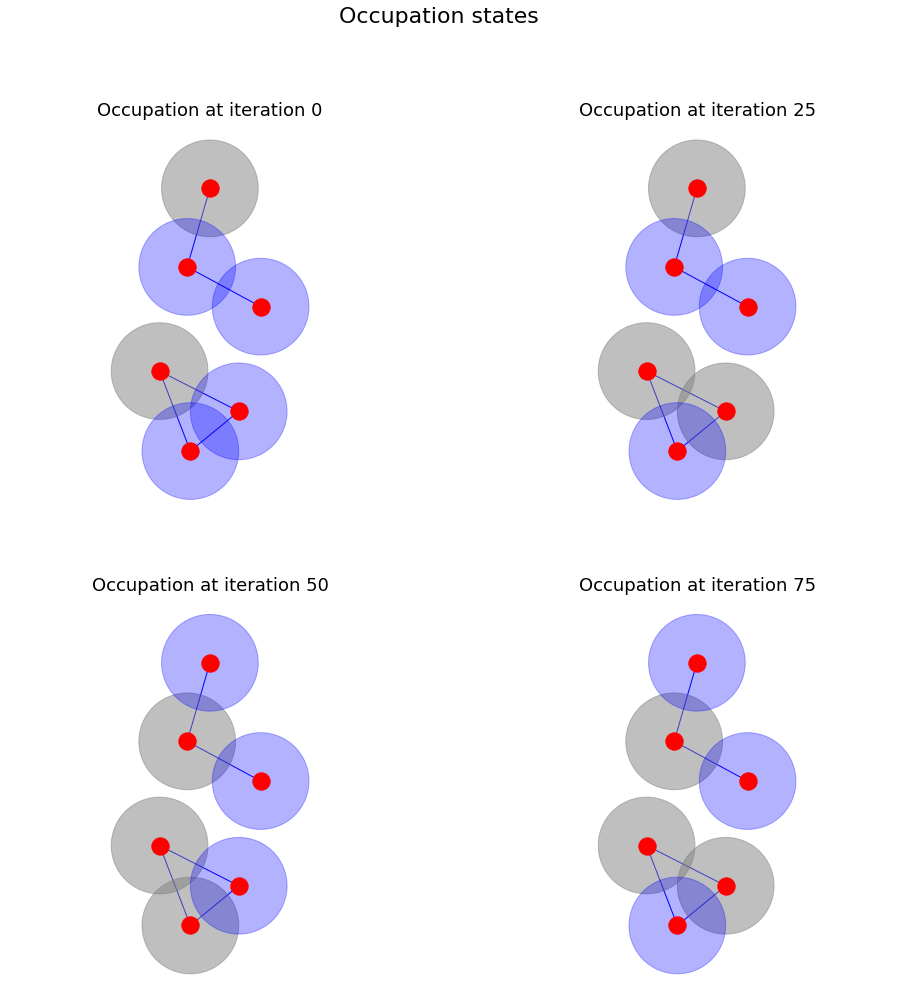

In [71]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states', fontsize=22)
draw_graph_state(udmis,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/Baseline_occupations.pdf', dpi=250, bbox_inches='tight')

In [ ]:
udmis.occupations

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

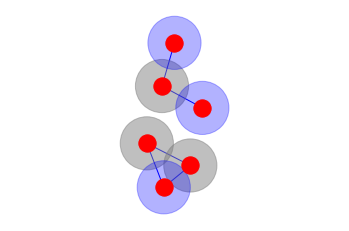

In [72]:
udmis.draw_graph()
#plt.savefig('figs task 1/Baseline_graph.pdf', dpi=250, bbox_inches='tight')

### Frange cicle

In [73]:
def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L 

In [74]:
udmis_frange = UDMIS(u,graph)

6


In [75]:
N = 100
t = np.arange(N+1)
T_i = 100
T_f = 0.01

In [76]:
T = frange_cycle_linear(N, start=T_f, stop=T_i)

In [ ]:
#T = T[::-1]

In [77]:
annealing_frange = np.zeros((N,3))
occupation_states = []
for i,t in enumerate(range(N)):
    temp = T[t]
    E, dE = udmis_frange.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_frange.occupations))
    annealing_frange[i,0] = temp
    annealing_frange[i,1] = E
    annealing_frange[i,2] = dE

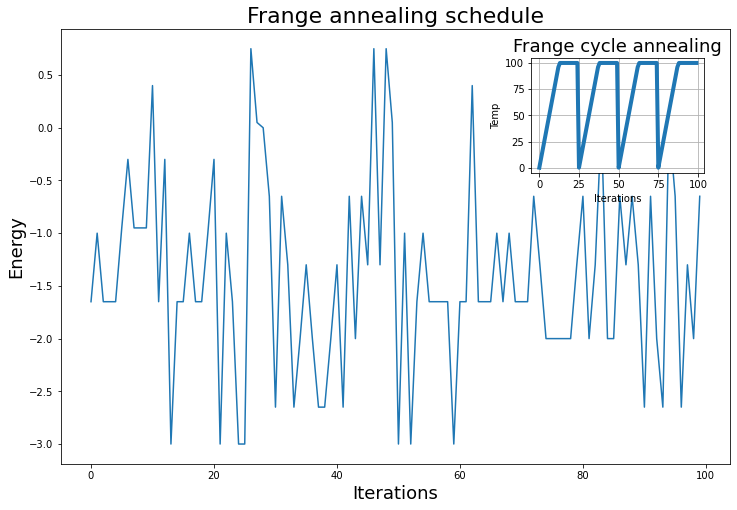

In [78]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_frange[:,1])
plt.title('Frange annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Frange cycle annealing', fontsize=18)
plt.plot(np.arange(N),T, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/FrangeCycle_annealing.pdf', dpi=250, bbox_inches='tight')

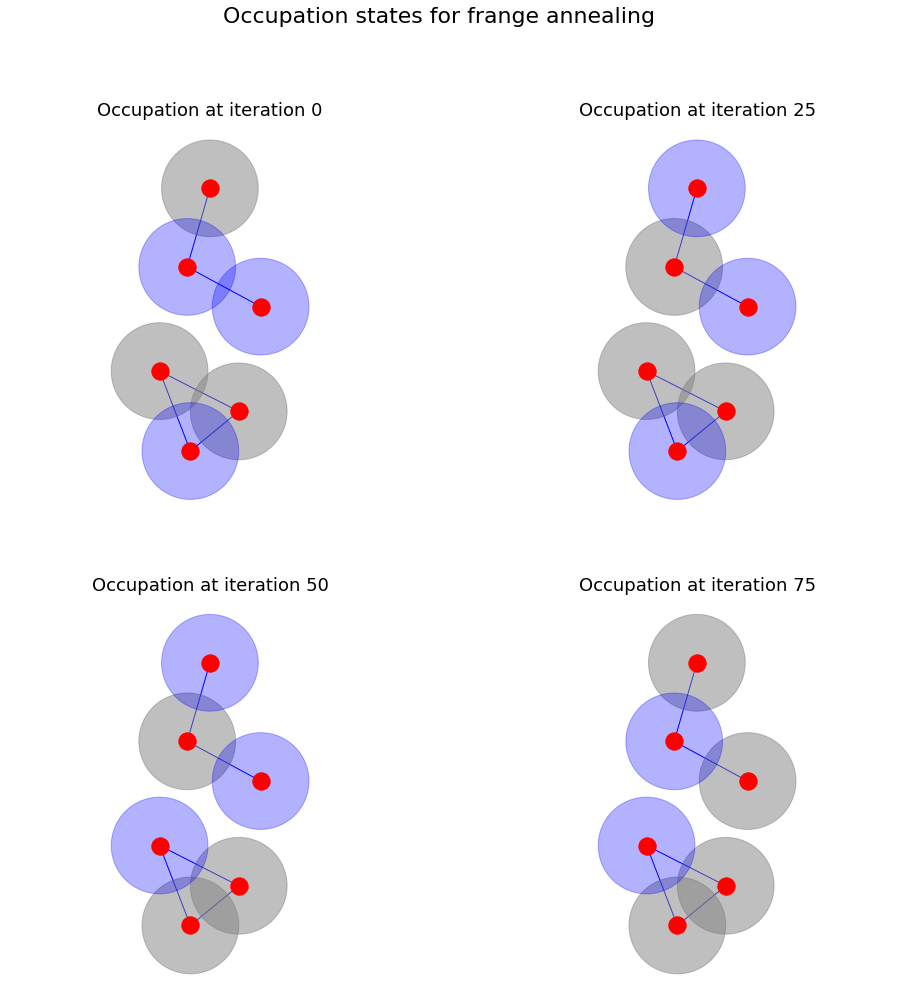

In [79]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for frange annealing', fontsize=22)
draw_graph_state(udmis_frange,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_frange,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_frange,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_frange,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/FrangeCycle_occupations.pdf', dpi=250, bbox_inches='tight')

### Is interesting but does not reach the ground state in 100 iterations

## LAMBDA annealing

$$T_k = T_{initial}∗\Lambda_{k}$$

In [80]:
udmis_LAMBDA = UDMIS(u,graph)

6


In [81]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [82]:
annealing_lambda = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_LAMBDA.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_LAMBDA.occupations))
    annealing_lambda[i,0] = temp
    annealing_lambda[i,1] = E
    annealing_lambda[i,2] = dE
    scheduler.step()

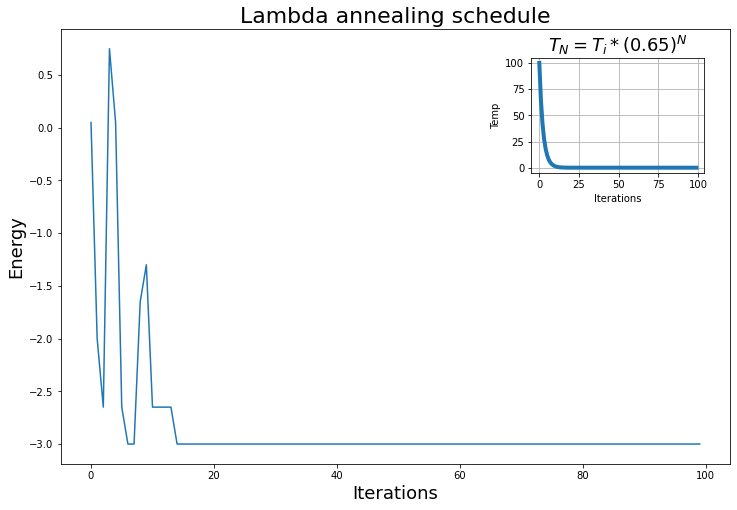

In [83]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_lambda[:,1])
plt.title('Lambda annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('$T_N = T_{i}*(0.65)^{N}$', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/Lambda_annealing.pdf', dpi=250, bbox_inches='tight')

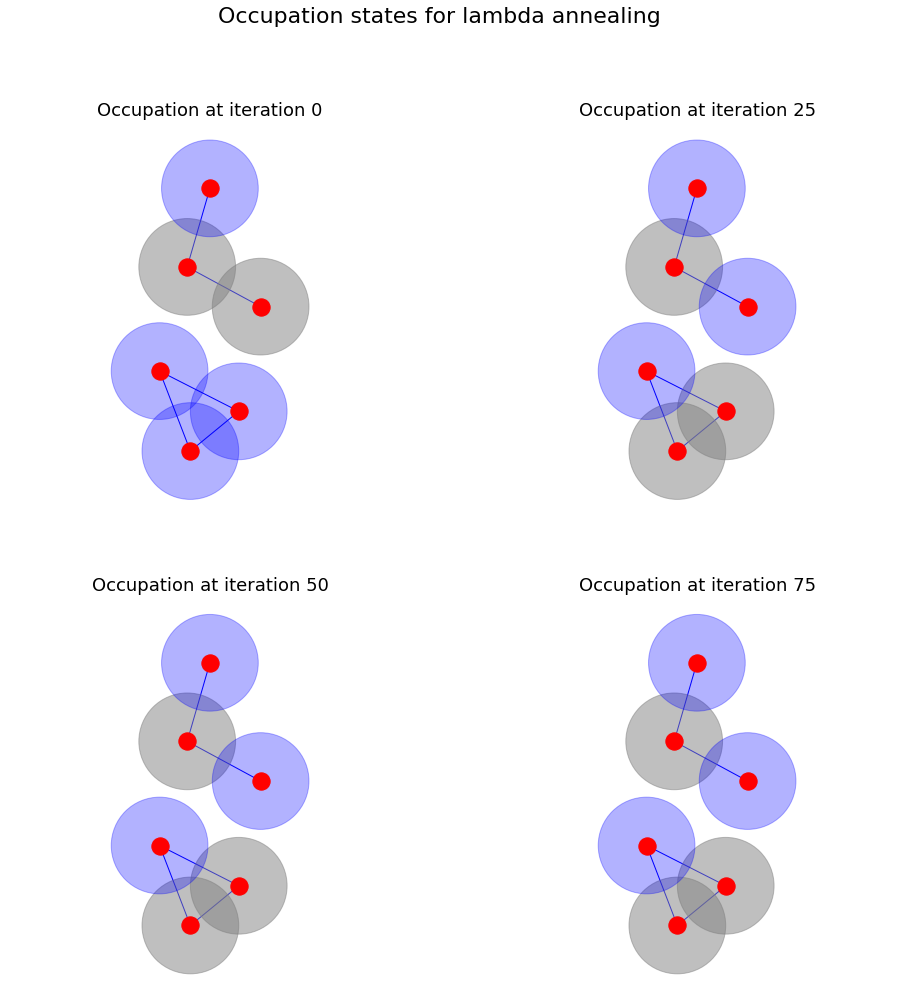

In [87]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for lambda annealing', fontsize=22)
draw_graph_state(udmis_LAMBDA,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_LAMBDA,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_LAMBDA,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_LAMBDA,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/lambda_occupations.pdf', dpi=250, bbox_inches='tight')

### It reaches the ground state faster, around 10 iterartions!!

## Multiplicative annealing

$$T_k= T_{k - 1}∗\Lambda_K$$

In [90]:
udmis_MultLAMBDA = UDMIS(u,graph)

6


In [91]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [92]:
annealing_Multlambda = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_MultLAMBDA.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_MultLAMBDA.occupations))
    annealing_Multlambda[i,0] = temp
    annealing_Multlambda[i,1] = E
    annealing_Multlambda[i,2] = dE
    scheduler.step()

/home/felipe/CDL tentativas/abstract_udmis.py:32: RuntimeWarning: overflow encountered in double_scalars
  if (dE < 0) or (np.random.rand() < np.exp(-dE/T)):
/home/felipe/CDL tentativas/abstract_udmis.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  if (dE < 0) or (np.random.rand() < np.exp(-dE/T)):


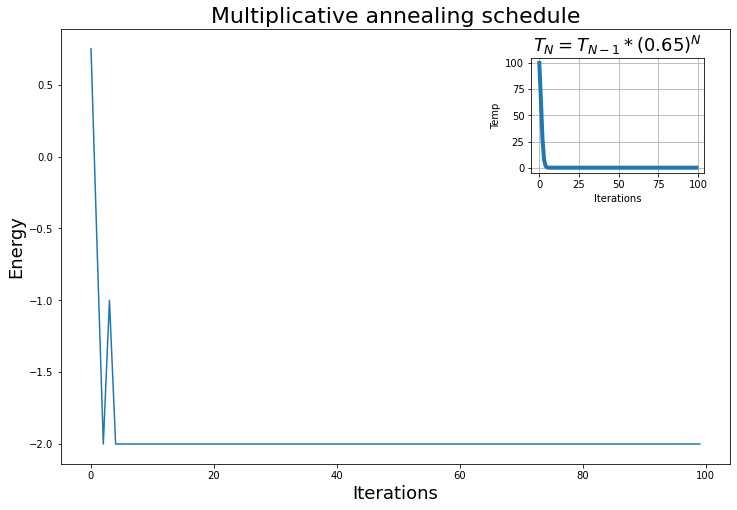

In [93]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_Multlambda[:,1])
plt.title('Multiplicative annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('$T_N = T_{N-1}*(0.65)^{N}$', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/Multiplicative_annealing.pdf', dpi=250, bbox_inches='tight')

### It reaches even faster!!!

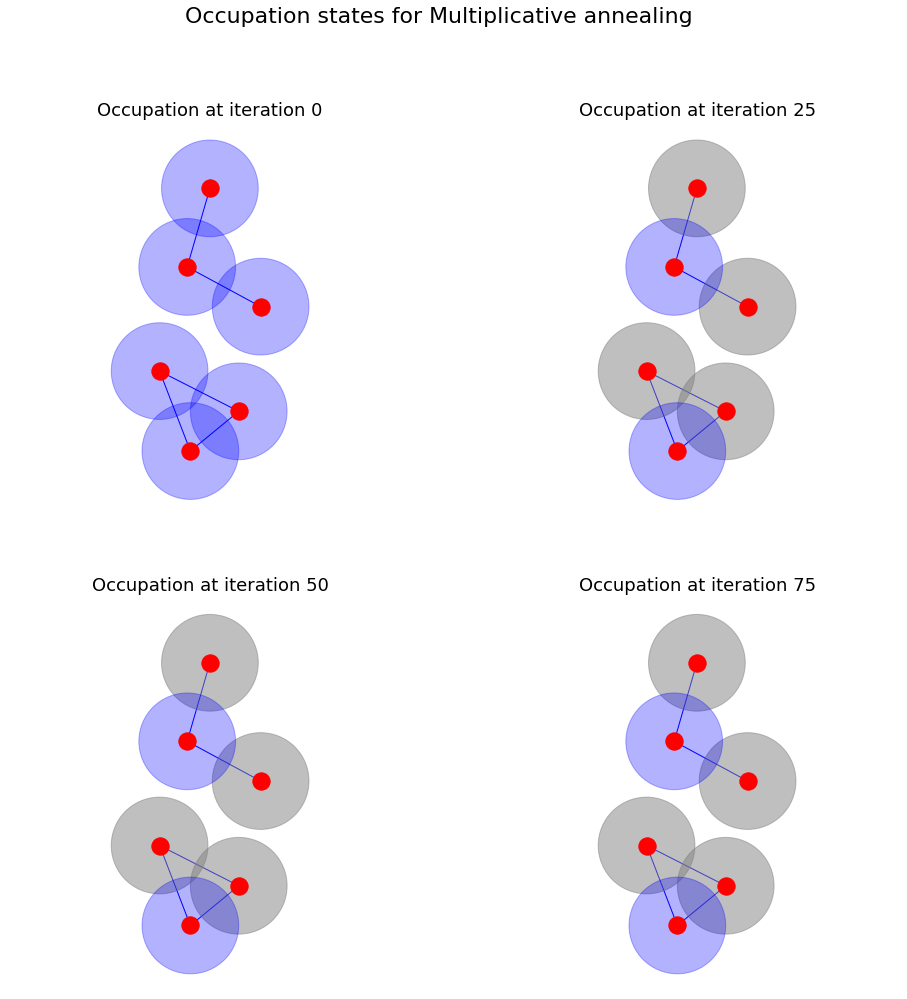

In [95]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Multiplicative annealing', fontsize=22)
draw_graph_state(udmis_MultLAMBDA,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_MultLAMBDA,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_MultLAMBDA,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_MultLAMBDA,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/Multiplicative_occupations.pdf', dpi=250, bbox_inches='tight')

## Step annealing

\begin{equation*}
T_{N} = \left\{
\begin{matrix} \Gamma∗T_{N - 1} & \text{if N % step_size=0}\\ 
T_{N - 1} & \text{otherwise}
\end{matrix}
\right.
\end{equation*}  

In [96]:
udmis_step = UDMIS(u,graph)

6


In [97]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [98]:
annealing_step = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_step.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_step.occupations))
    annealing_step[i,0] = temp
    annealing_step[i,1] = E
    annealing_step[i,2] = dE
    scheduler.step()

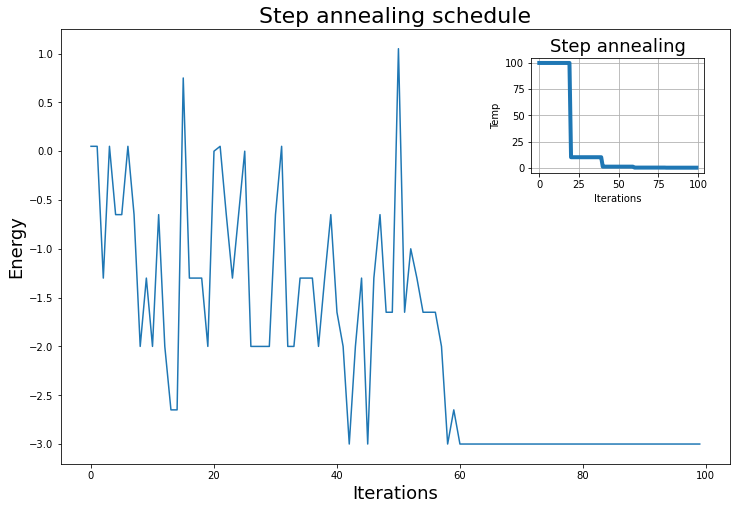

In [99]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_step[:,1])
plt.title('Step annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Step annealing', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/Step_annealing.pdf', dpi=250, bbox_inches='tight')

It got there, but quite late.

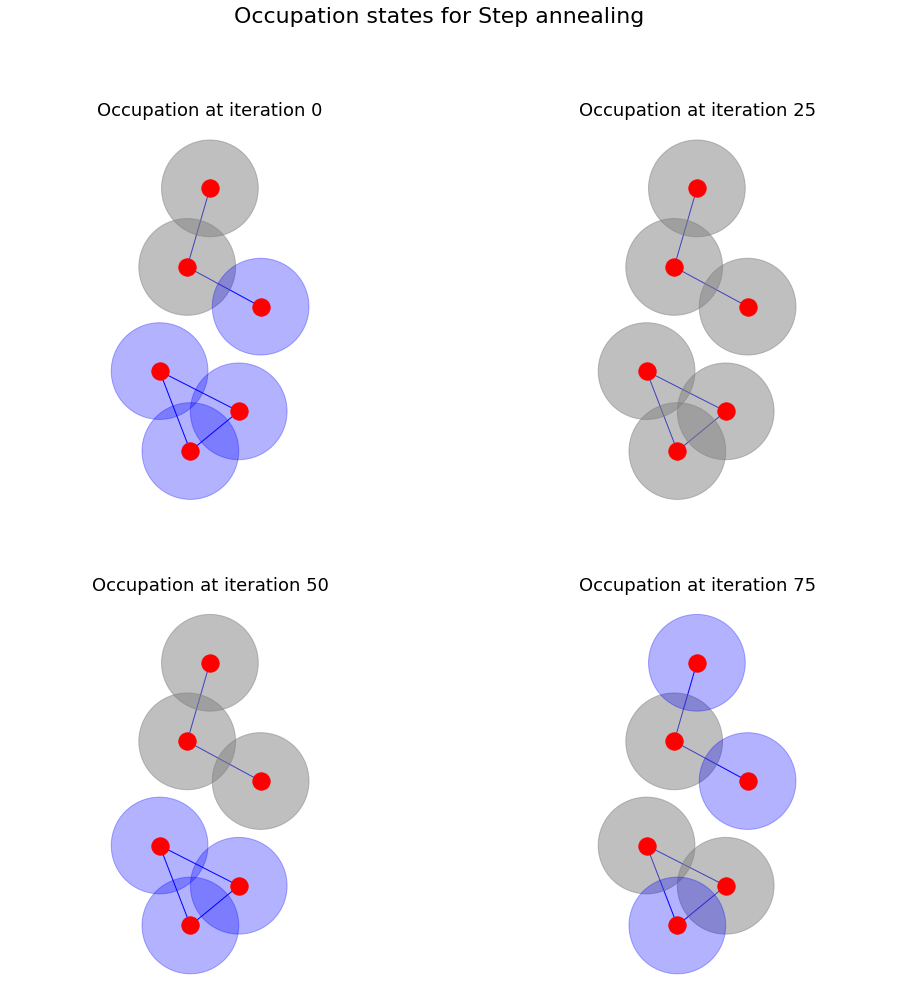

In [100]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Step annealing', fontsize=22)
draw_graph_state(udmis_step,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_step,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_step,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_step,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/Step_occupations.pdf', dpi=250, bbox_inches='tight')

## MultiStep annealing

\begin{equation*}
T_{N} = \left\{
\begin{matrix} \Gamma∗T_{N - 1} & \text{if  epoch in [milestones]}\\ 
T_{N - 1} & \text{otherwise}
\end{matrix}
\right.
\end{equation*}

In [101]:
udmis_multistep = UDMIS(u,graph)

6


In [102]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,80,90], gamma=0.1)

In [103]:
annealing_multistep = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_multistep.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_multistep.occupations))
    annealing_multistep[i,0] = temp
    annealing_multistep[i,1] = E
    annealing_multistep[i,2] = dE
    scheduler.step()

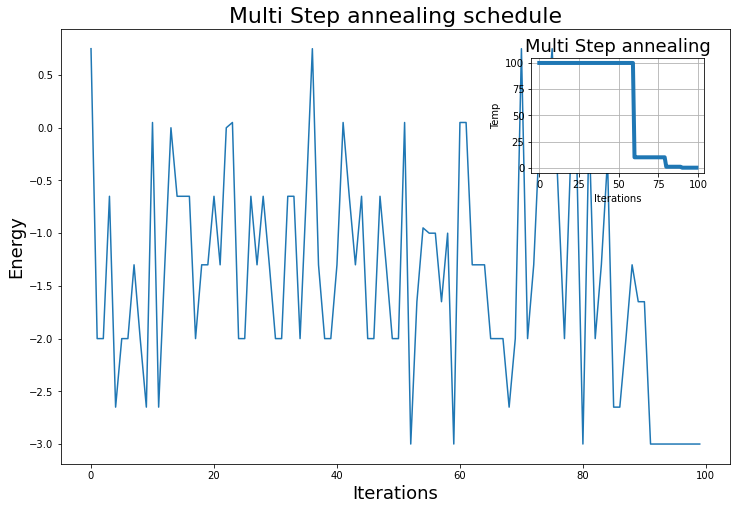

In [104]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_multistep[:,1])
plt.title('Multi Step annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Multi Step annealing', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/MultiStep_annealing.pdf', dpi=250, bbox_inches='tight')

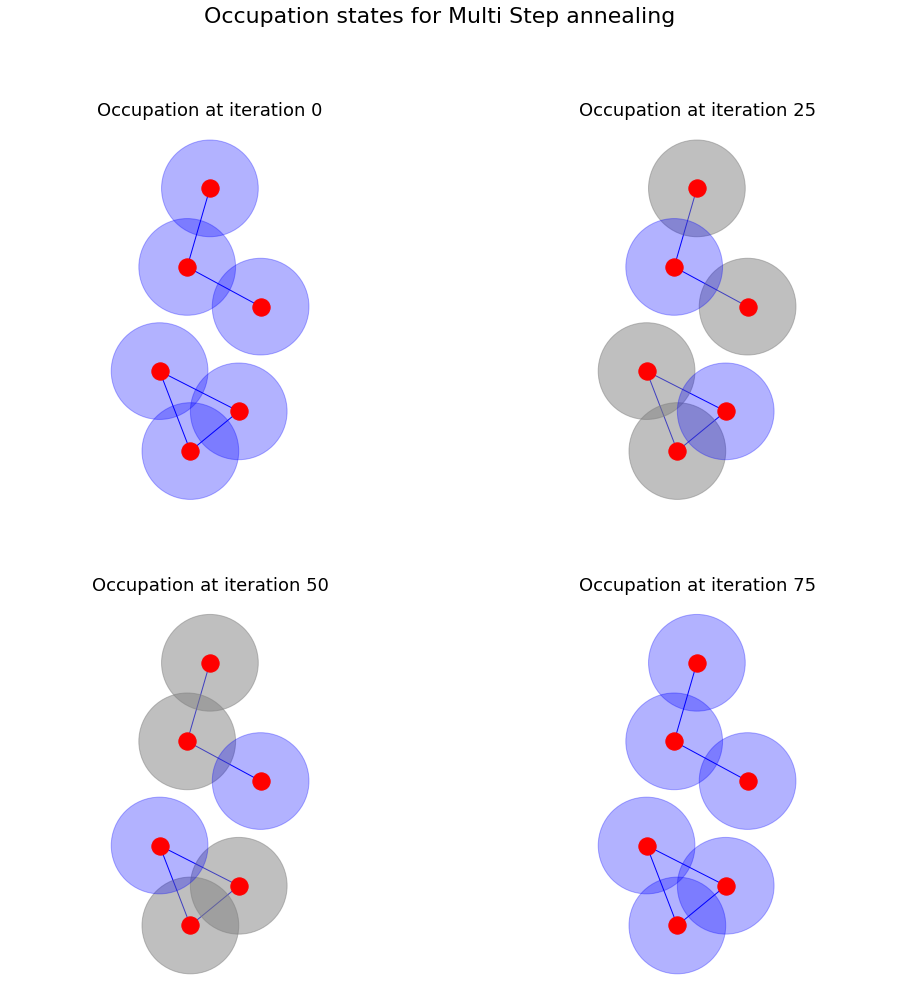

In [105]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Multi Step annealing', fontsize=22)
draw_graph_state(udmis_multistep,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_multistep,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_multistep,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_multistep,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/MultiStep_occupations.pdf', dpi=250, bbox_inches='tight')

# Exponential annealing

$$T_{N}=\Gamma∗T_{N-1}$$

In [106]:
udmis_exponential = UDMIS(u,graph)

6


In [107]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

In [108]:
annealing_exponential = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_exponential.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_exponential.occupations))
    annealing_exponential[i,0] = temp
    annealing_exponential[i,1] = E
    annealing_exponential[i,2] = dE
    scheduler.step()

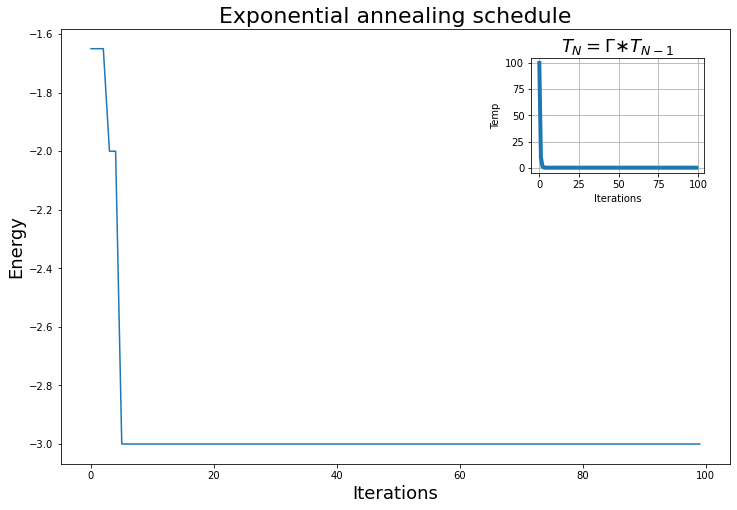

In [109]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_exponential[:,1])
plt.title('Exponential annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('$T_{N}=\Gamma∗T_{N-1}$', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/Exponential_annealing.pdf', dpi=250, bbox_inches='tight')

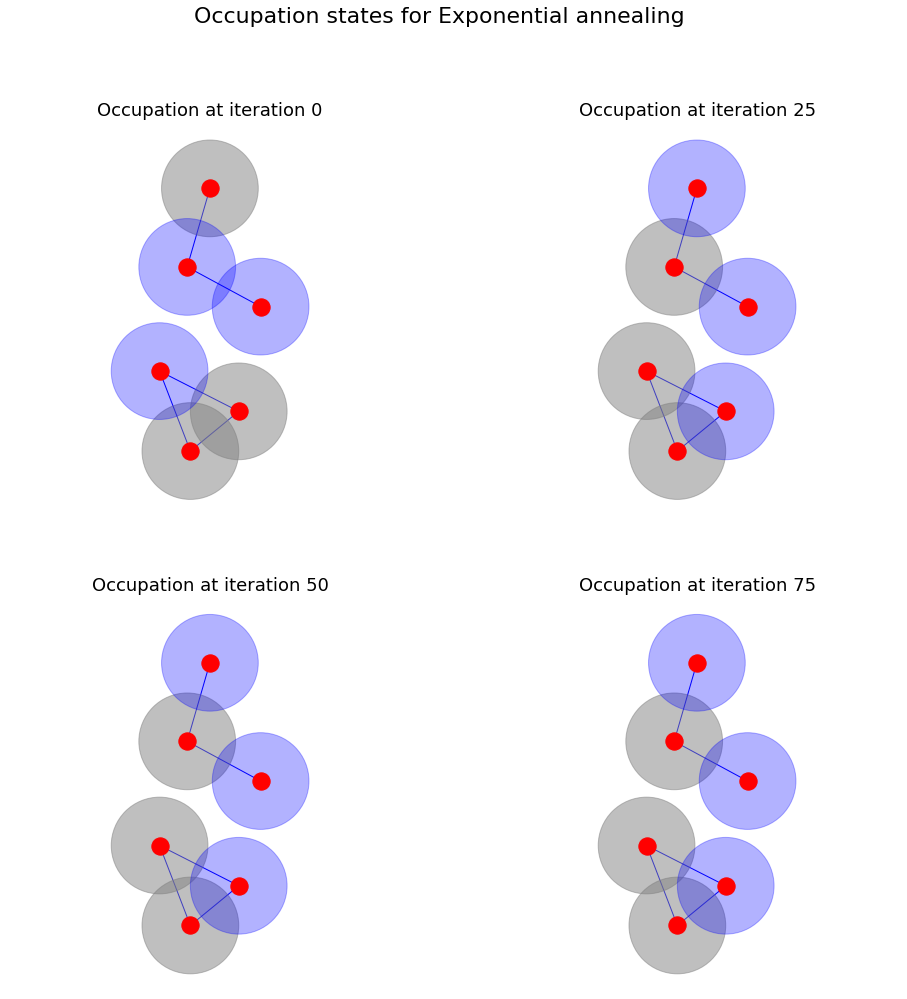

In [110]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Exponential annealing', fontsize=22)
draw_graph_state(udmis_exponential,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_exponential,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_exponential,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_exponential,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/Exponential_occupations.pdf', dpi=250, bbox_inches='tight')

Quite fast boy

## CosineAnnealing

$$ T=T_{min} + \frac{1}{2}(T_{max}-T_{min})\left(1+cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right)$$

In [111]:
udmis_CosineAnnealing = UDMIS(u,graph)

6


In [112]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=11, eta_min=0)

In [113]:
annealing_CosineAnnealing = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()    
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_CosineAnnealing.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_CosineAnnealing.occupations))
    annealing_CosineAnnealing[i,0] = temp
    annealing_CosineAnnealing[i,1] = E
    annealing_CosineAnnealing[i,2] = dE
    scheduler.step()

/home/felipe/CDL tentativas/abstract_udmis.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  if (dE < 0) or (np.random.rand() < np.exp(-dE/T)):


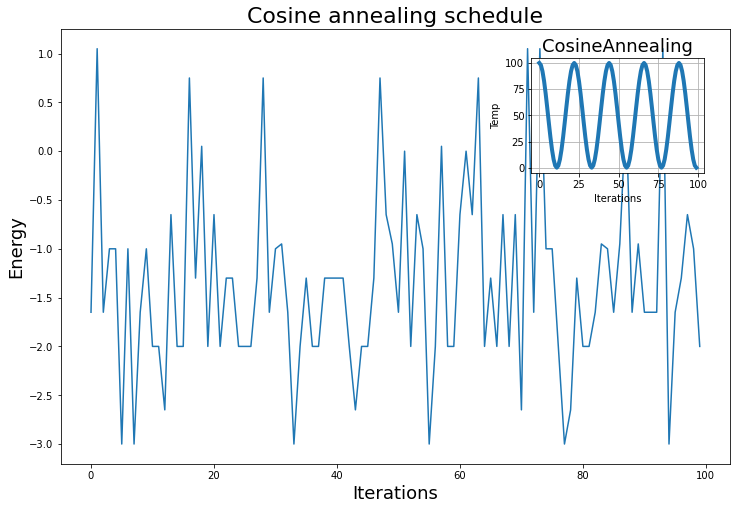

In [114]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_CosineAnnealing[:,1])
plt.title('Cosine annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('CosineAnnealing', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/CosineAnnealing_annealing.pdf', dpi=250, bbox_inches='tight')

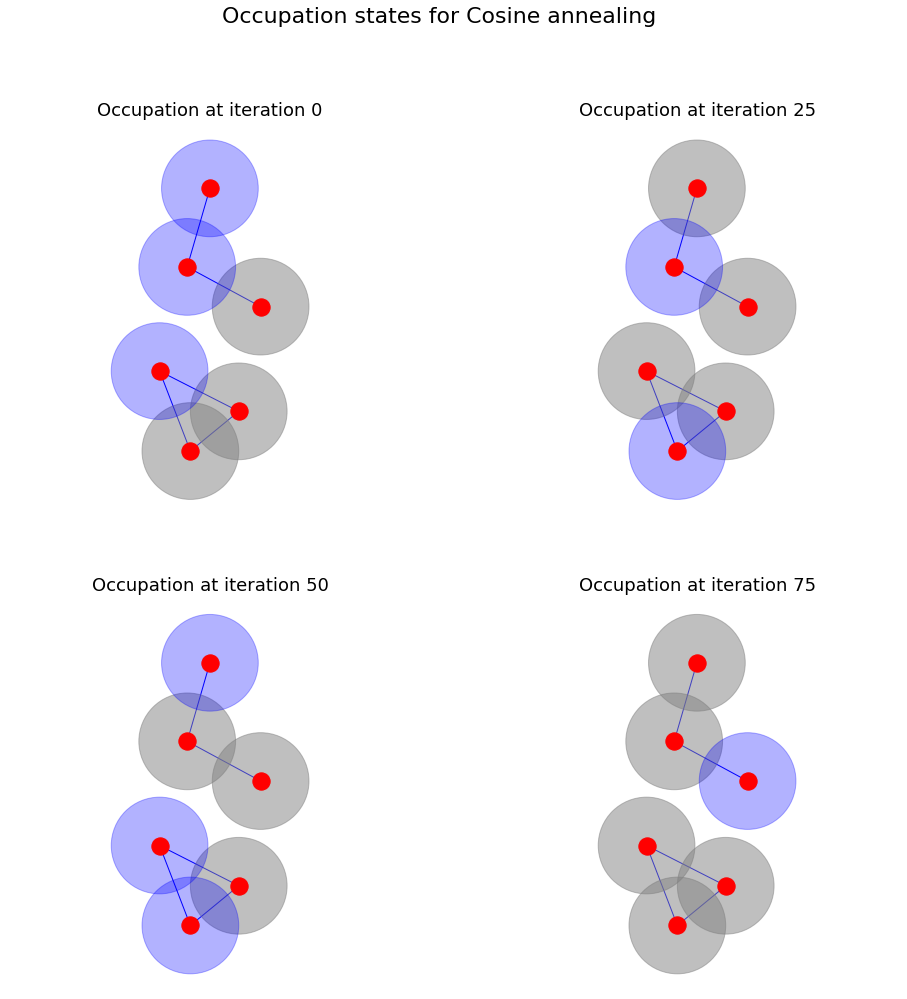

In [115]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Cosine annealing', fontsize=22)
draw_graph_state(udmis_CosineAnnealing,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_CosineAnnealing,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_CosineAnnealing,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_CosineAnnealing,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/CosineAnnealing_occupations.pdf', dpi=250, bbox_inches='tight')

## Cyclic annealing - triangular

In [116]:
udmis_CyclicTriangular = UDMIS(u,graph)

6


In [117]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=(T_f/T_i), max_lr=T_i,step_size_up=5,mode="triangular")

In [118]:
annealing_CyclicTriangula = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_CyclicTriangular.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_CyclicTriangular.occupations))    
    annealing_CyclicTriangula[i,0] = temp
    annealing_CyclicTriangula[i,1] = E
    annealing_CyclicTriangula[i,2] = dE
    scheduler.step()

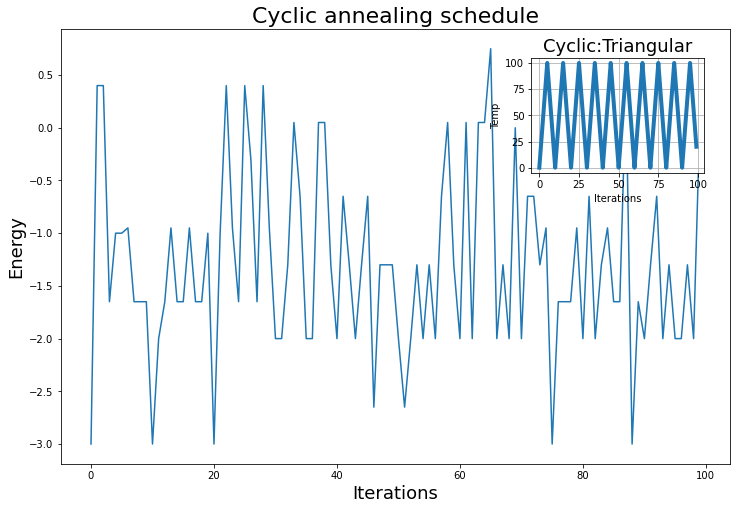

In [120]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_CyclicTriangula[:,1])
plt.title('Cyclic annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Cyclic:Triangular', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/CyclicTriangula_annealing.pdf', dpi=250, bbox_inches='tight')

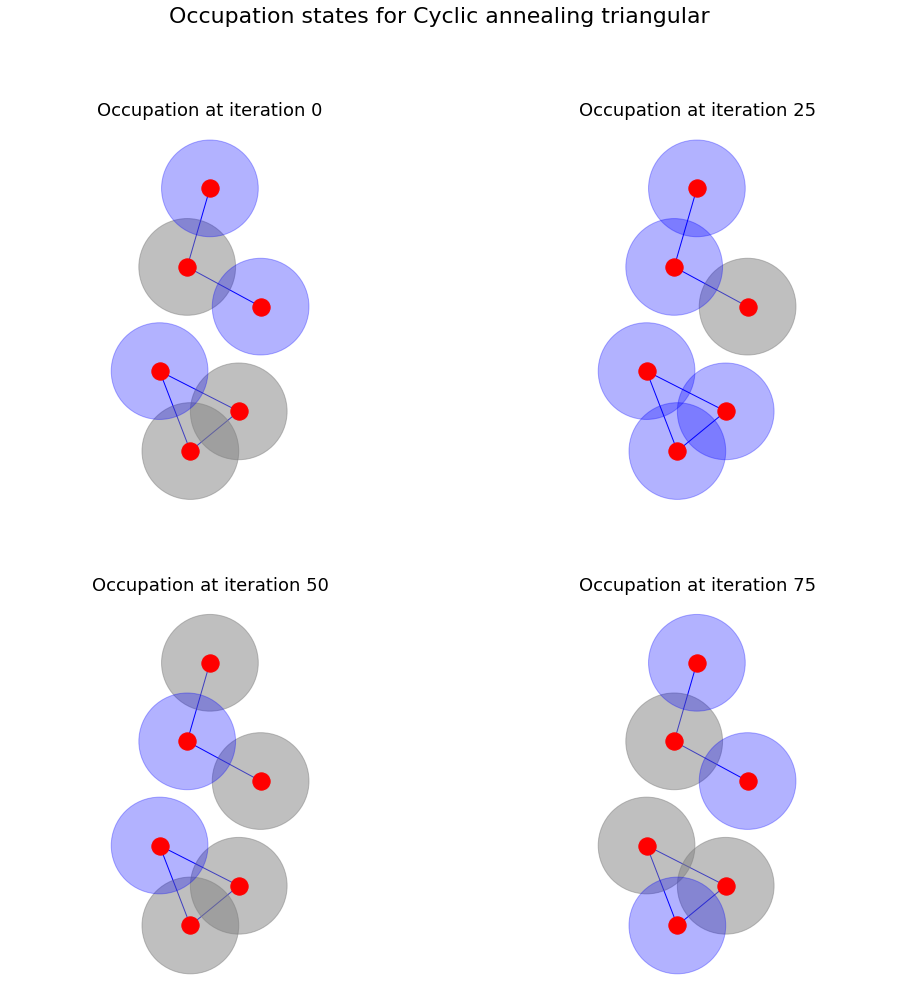

In [121]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Cyclic annealing triangular', fontsize=22)
draw_graph_state(udmis_CyclicTriangular,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_CyclicTriangular,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_CyclicTriangular,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_CyclicTriangular,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/CyclicTriangula_occupations.pdf', dpi=250, bbox_inches='tight')

## Cyclic annealing - triangular 2

In [122]:
udmis_CyclicTriangular2 = UDMIS(u,graph)

6


In [123]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=(T_f/T_i), max_lr=T_i,step_size_up=5,mode="triangular2")

In [124]:
annealing_CyclicTriangula2 = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_CyclicTriangular2.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_CyclicTriangular2.occupations))    
    annealing_CyclicTriangula2[i,0] = temp
    annealing_CyclicTriangula2[i,1] = E
    annealing_CyclicTriangula2[i,2] = dE
    scheduler.step()

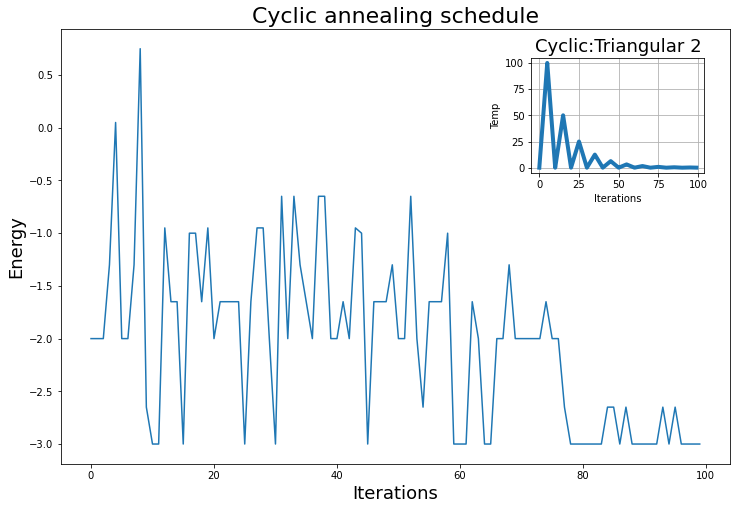

In [125]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_CyclicTriangula2[:,1])
plt.title('Cyclic annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Cyclic:Triangular 2', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/CyclicTriangula2_annealing.pdf', dpi=250, bbox_inches='tight')

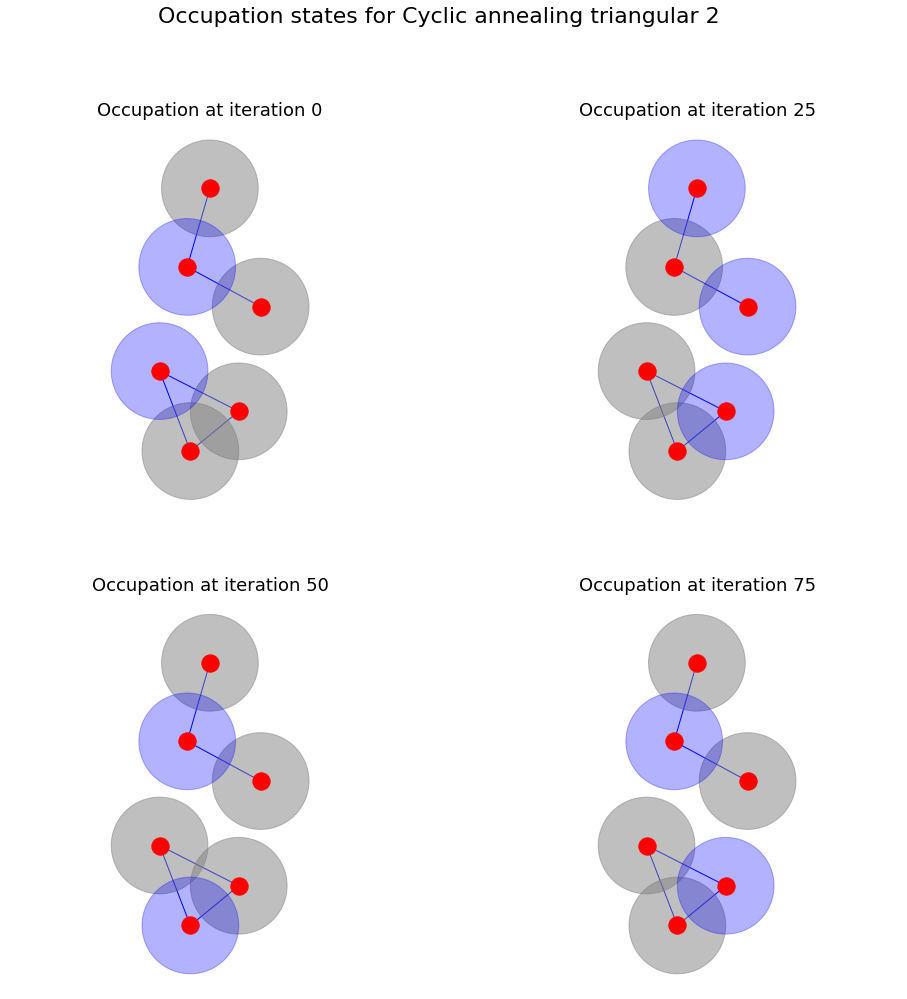

In [126]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Cyclic annealing triangular 2', fontsize=22)
draw_graph_state(udmis_CyclicTriangular2,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_CyclicTriangular2,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_CyclicTriangular2,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_CyclicTriangular2,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/CyclicTriangula2_occupations.pdf', dpi=250, bbox_inches='tight')

## Cyclic - exp_range

In [131]:
udmis_CyclicExp = UDMIS(u,graph)

6


In [132]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=100)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=(T_f/T_i), max_lr=T_i,step_size_up=5,mode="exp_range",gamma=0.85)

In [133]:
annealing_CyclicExp = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_CyclicExp.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_CyclicExp.occupations))    
    annealing_CyclicExp[i,0] = temp
    annealing_CyclicExp[i,1] = E
    annealing_CyclicExp[i,2] = dE
    scheduler.step()

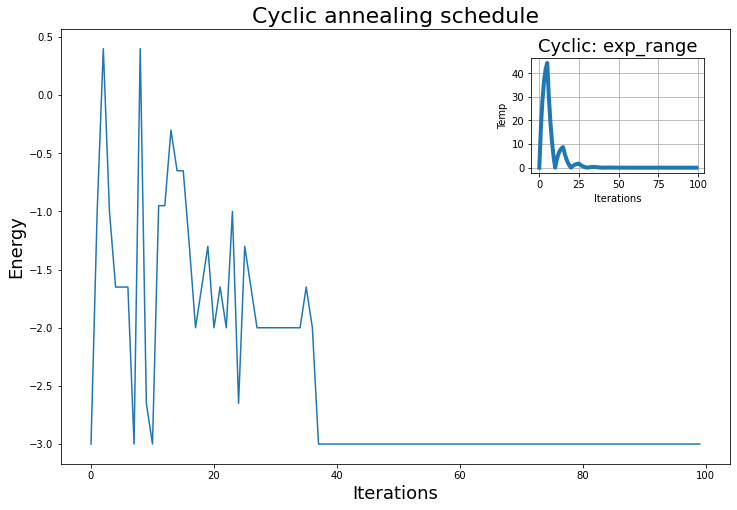

In [134]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_CyclicExp[:,1])
plt.title('Cyclic annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('Cyclic: exp_range', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/CyclicExp_annealing.pdf', dpi=250, bbox_inches='tight')

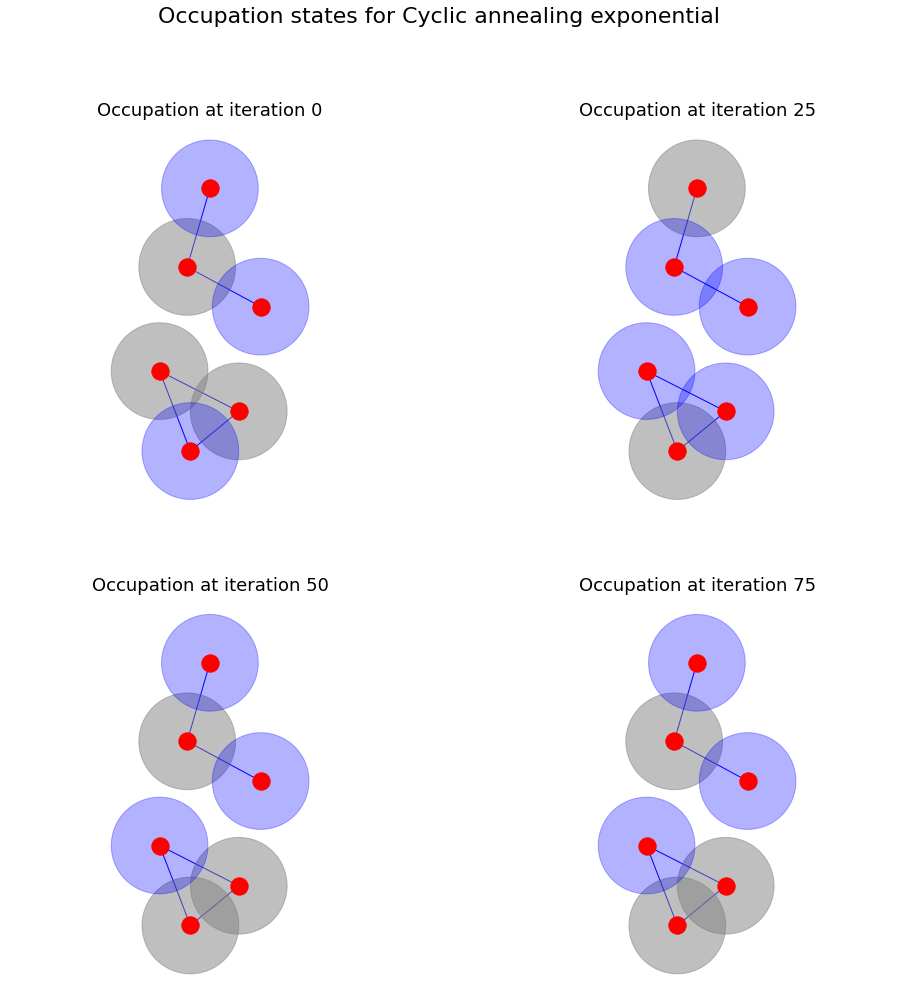

In [135]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for Cyclic annealing exponential', fontsize=22)
draw_graph_state(udmis_CyclicExp,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_CyclicExp,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_CyclicExp,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_CyclicExp,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/CyclicExp_occupations.pdf', dpi=250, bbox_inches='tight')

## OneCycle - cos

In [136]:
udmis_OneCycle = UDMIS(u,graph)

6


In [137]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=T_i, steps_per_epoch=10, epochs=10)

In [138]:
annealing_OneCycle = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_OneCycle.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_OneCycle.occupations))    
    annealing_OneCycle[i,0] = temp
    annealing_OneCycle[i,1] = E
    annealing_OneCycle[i,2] = dE
    scheduler.step()

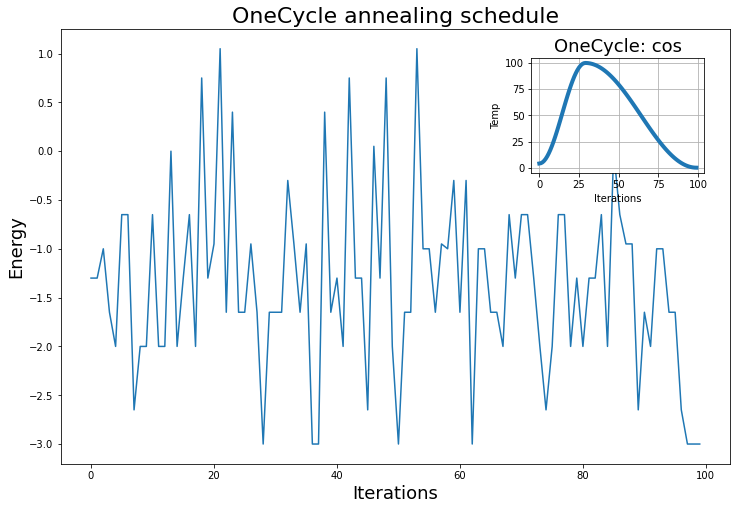

In [139]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_OneCycle[:,1])
plt.title('OneCycle annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('OneCycle: cos', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/OneCycle_annealing.pdf', dpi=250, bbox_inches='tight')

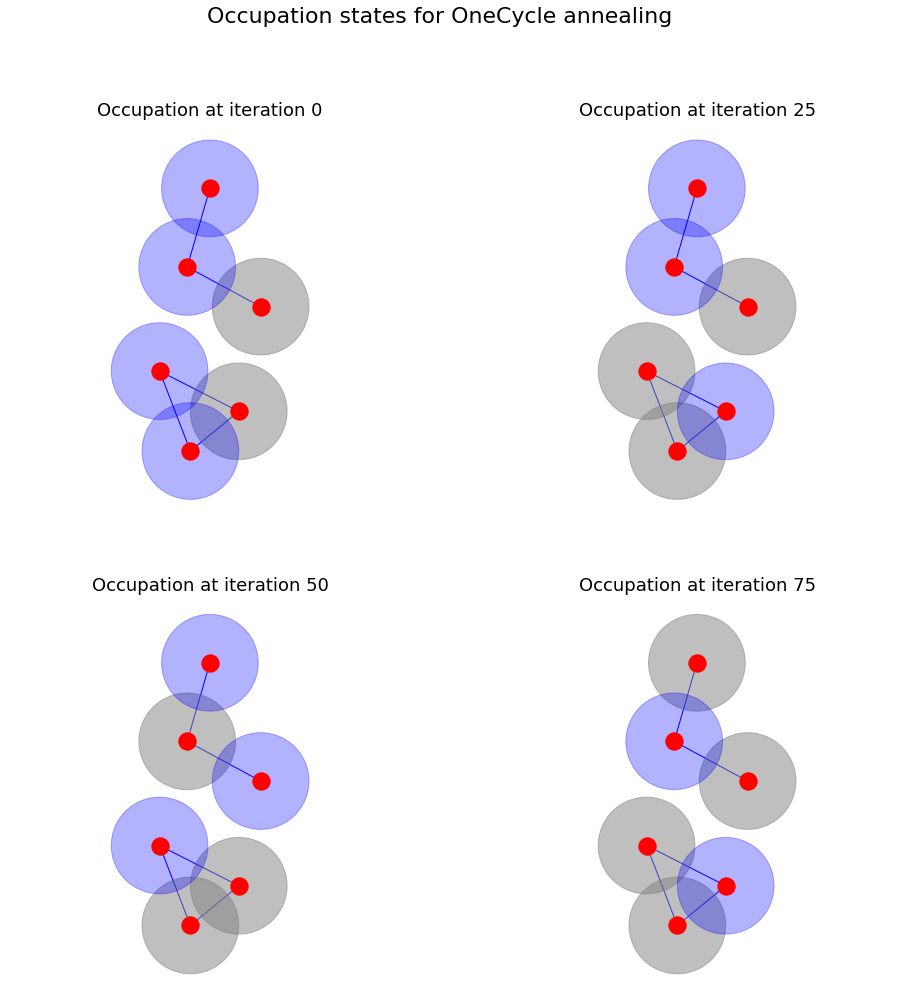

In [140]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for OneCycle annealing', fontsize=22)
draw_graph_state(udmis_OneCycle,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_OneCycle,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_OneCycle,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_OneCycle,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/OneCycle_occupations.pdf', dpi=250, bbox_inches='tight')

## OneCycle - linear

In [141]:
udmis_OneCycleLinear = UDMIS(u,graph)

6


In [142]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=T_i)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=T_i, steps_per_epoch=10, epochs=10,anneal_strategy='linear')

In [143]:
annealing_OneCycleLinear = np.zeros((N,3))
temps = []
occupation_states = []
for i,t in enumerate(range(N)):
    optimizer.step()
    temp = optimizer.param_groups[0]["lr"]
    temps.append(optimizer.param_groups[0]["lr"])
    E, dE = udmis_OneCycleLinear.mc_step(T=temp)
    if i%(N//4) == 0:
        occupation_states.append(np.array(udmis_OneCycleLinear.occupations))        
    annealing_OneCycleLinear[i,0] = temp
    annealing_OneCycleLinear[i,1] = E
    annealing_OneCycleLinear[i,2] = dE
    scheduler.step()

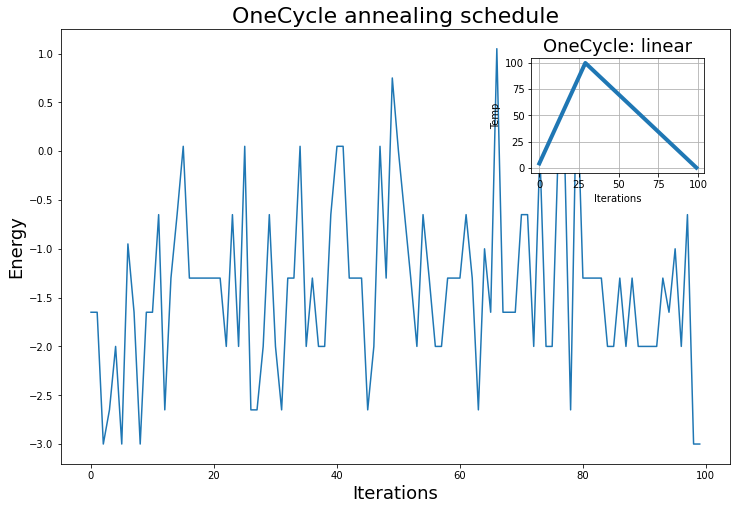

In [144]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(N),annealing_OneCycleLinear[:,1])
plt.title('OneCycle annealing schedule', fontsize=22)
plt.ylabel('Energy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
a = plt.axes([.67, .63, .20, .20])
plt.title('OneCycle: linear', fontsize=18)
plt.plot(np.arange(N),temps, lw=4.)
plt.ylabel('Temp')
plt.xlabel('Iterations')
plt.grid()
#plt.savefig('figs task 1/OneCycle_annealing.pdf', dpi=250, bbox_inches='tight')

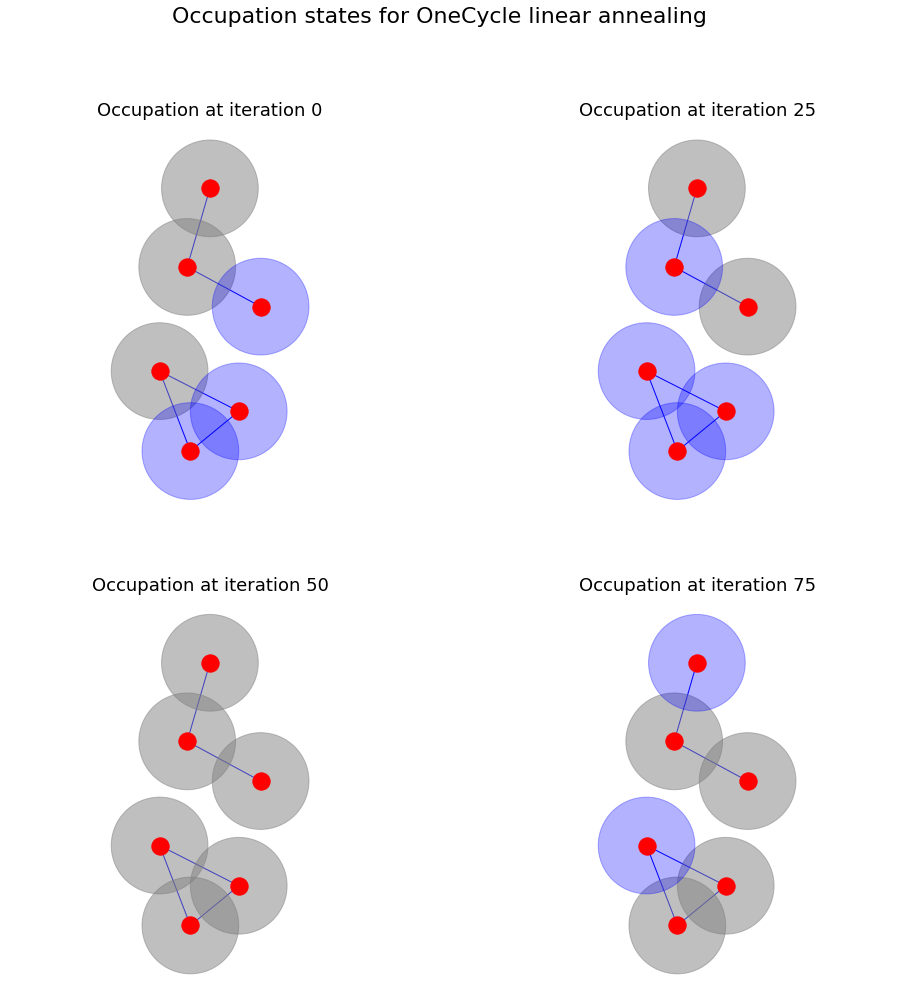

In [145]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,16))
fig.suptitle('Occupation states for OneCycle linear annealing', fontsize=22)
draw_graph_state(udmis_OneCycleLinear,occupation_states[0],ax1)
ax1.set_title('Occupation at iteration 0', fontsize=18)
draw_graph_state(udmis_OneCycleLinear,occupation_states[1],ax2)
ax2.set_title('Occupation at iteration 25', fontsize=18)
draw_graph_state(udmis_OneCycleLinear,occupation_states[2],ax3)
ax3.set_title('Occupation at iteration 50', fontsize=18)
draw_graph_state(udmis_OneCycleLinear,occupation_states[3],ax4)
ax4.set_title('Occupation at iteration 75', fontsize=18)
plt.savefig('figs task 1/OneCycleLinear_occupations.pdf', dpi=250, bbox_inches='tight')